In [133]:
import pandas as pd 
import tensorflow as tf
import glob
import librosa
import numpy as np
from pydub import AudioSegment
from pydub.utils import make_chunks

file_paths = glob.glob("E:/Users/atag3/Documents/Gunshot_Data/*.wav")
labels = [os.path.basename(x) for x in glob.glob('E:/Users/atag3/Documents/Gunshot_Data/*.wav')]

dat = {'file_path':file_paths,'label':labels}
gun_dat = pd.DataFrame(dat)


# Find max mel spect size

In [131]:
import soundfile as sf
# Creating an empty list to store sizes in
sizes = []

# Looping through each audio file
for file in file_paths:
        
    # Loading in the audio file
    # add sr=32000 if foinf PANNS tranfer learning route.
    y, sr = librosa.core.load(file, sr=44100)
    #trimmed, index = librosa.effects.trim(y, top_db=20, frame_length=512, hop_length=512)
        
    # Computing the mel spectrograms
    #spect = librosa.feature.melspectrogram(y=trimmed, sr=sr, n_fft=1012, hop_length=256,n_mels=128, fmin=250)
    #spect = librosa.amplitude_to_db(spect, ref=np.max)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    
    # Adding the size to the list
    sizes.append(mfccs_processed.shape)

    # Create Noise augment data while looping
    #wav_n = y + 0.009*np.random.normal(0,1,len(y))
    #sf.write(file+'_noise_add.wav',wav_n,sr,'PCM_16')

    # Create Noise augment data while looping
    wav_n = y + 0.05*np.random.normal(0,1,len(y))
    sf.write(file+'_noise_add.wav',wav_n,sr,'PCM_16')



    myaudio = AudioSegment.from_file(file, "wav") 
    chunk_length_ms = 500 # pydub calculates in millisec
    chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

    #Export all of the individual chunks as wav files

    for i, chunk in enumerate(chunks):
        chunk_name = file+"chunk{0}.wav".format(i)
        #print "exporting", chunk_name
        chunk.export(chunk_name, format="wav")
    
# Checking if all sizes are the same
print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

# Checking the max size
print(f'The maximum size is: {max(sizes)}')

The sizes of all the mel spectrograms in our data set are equal: True
The maximum size is: (40,)


In [134]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name,sr=44100)

        #trimmed, index = librosa.effects.trim(audio, top_db=20, frame_length=512, hop_length=256)
        
        # try mfccs instead
        #mel_spect = librosa.feature.melspectrogram(y=trimmed, n_fft=1012, hop_length=256,n_mels=128, fmin=250)
        #mel_spect = librosa.amplitude_to_db(mel_spect, ref=np.max)

        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T,axis=0)
        
        # Adjusting the size to be 128 x 231
        #if mel_spect.shape[1] != 461:
        #   mel_spect.resize(128,461, refcheck=False)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs_processed
    
    
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
features = []

# Iterate through each sound file and extract the features 
for i in range(len(file_paths)):
    
    class_label = labels[i].split("_")[0]
    data = extract_features(file_paths[i])
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  5307  files


In [507]:
featuresdf.feature.shape

(193,)

(128, 38)

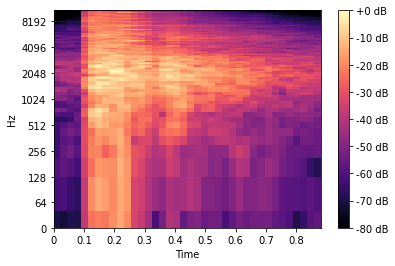

In [48]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import librosa.display

audio, sample_rate = librosa.load(file_paths[20]) 

#trimmed, index = librosa.effects.trim(audio, top_db=20, frame_length=512, hop_length=512)
mel_spect = librosa.feature.melspectrogram(y=audio)
DB = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(DB, sr=sample_rate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB')
mel_spect.shape


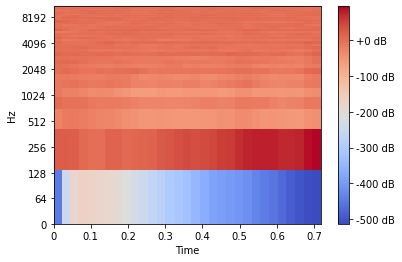

In [50]:
audio, sample_rate = librosa.load(file_paths[100]) 
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
#DB = np.mean(mfccs.T,axis=0)
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB')

In [51]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17553004888339039591
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16868177184580085760
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3027927634797580524
physical_device_desc: "device: XLA_GPU device"
]


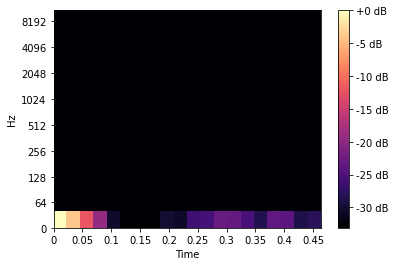

In [684]:
audio, sample_rate = librosa.load('output.wav') 

trimmed, index = librosa.effects.trim(audio, top_db=20, frame_length=512, hop_length=512)
mel_spect = librosa.feature.melspectrogram(y=trimmed, n_fft=2048, hop_length=512,n_mels=128)
DB = librosa.amplitude_to_db(mel_spect, ref=np.max)
librosa.display.specshow(DB, sr=sample_rate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB')


In [135]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.3, random_state = 42)

In [136]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Conv1D, Convolution1D, MaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
import tensorflow as tf
from keras.callbacks import EarlyStopping





In [137]:
x_train = x_train.reshape(x_train.shape[0], 40,1)
x_test = x_test.reshape(x_test.shape[0], 40,1)

num_labels = yy.shape[1]
filter_size = 2


# Construct model 
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, input_shape=(40,1), activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Activation('relu'))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))#
model.add(MaxPooling1D(pool_size=(2)))
model.add(Activation('relu'))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(units = 120, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 84, activation = 'relu'))
model.add(Dense(units = 10, activation = 'relu'))
#model.add(GlobalAveragePooling2D())

model.add(Dense(3, activation='softmax'))

# another model
#model =Sequential()
#model.add(Dense(256, activation="relu", input_shape=input_shape))
#model.add(Dense(128, activation="relu", input_shape=input_shape))
#model.add(Dense(64, activation="relu", input_shape=input_shape))
#model.add(Dense(3, activation = "softmax"))

In [612]:
x_train = x_train.reshape(x_train.shape[0],40,1)
x_test = x_test.reshape(x_test.shape[0], 40,1)

#Another shorter model
#Define Model
model = Sequential()
model.add(Conv1D(32, kernel_size=(3), activation='relu', input_shape=(40,1)))
model.add(Conv1D(64, kernel_size=(3), activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [514]:
x_train.shape

(154, 40, 1)

In [138]:
# Compile the model
model.compile(loss='kullback_leibler_divergence', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 38, 16)            64        
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 19, 16)            0         
_________________________________________________________________
activation_18 (Activation)   (None, 19, 16)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 17, 32)            1568      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
activation_19 (Activation)   (None, 8, 32)             0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 6, 64)            

In [139]:
score = model.evaluate(x_test, y_test, verbose=1)

50/50 [==============================] - 0s 3ms/step - loss: 2.0755 - accuracy: 0.1368


In [140]:
def train(model,X_train, X_test, y_train, y_test):    

    # compile the model 
    model.compile(loss = 'kullback_leibler_divergence',metrics=['accuracy'],optimizer='adam')

    print(model.summary())

    print("training for 100 epochs with batch size 20")
    
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20, restore_best_weights=True )

    model.fit(X_train,y_train,batch_size= 5, epochs = 100, validation_data=(X_test,y_test),callbacks=[es])

    # save model to disk
    print("Saving model to disk")

In [144]:
def compute(X_test,y_test,model):

    # load model from disk
    loaded_model = model
    score = loaded_model.evaluate(X_test,y_test)
    return score[0],score[1]*100

In [177]:
fast_mod = create_mlp(3)

In [141]:
train(model,x_train,x_test,y_train,y_test)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 38, 16)            64        
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 19, 16)            0         
_________________________________________________________________
activation_18 (Activation)   (None, 19, 16)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 17, 32)            1568      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
activation_19 (Activation)   (None, 8, 32)             0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 6, 64)            

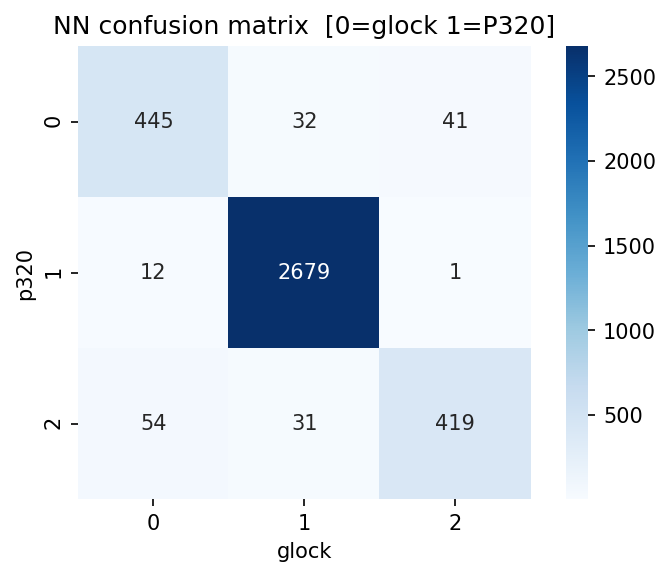

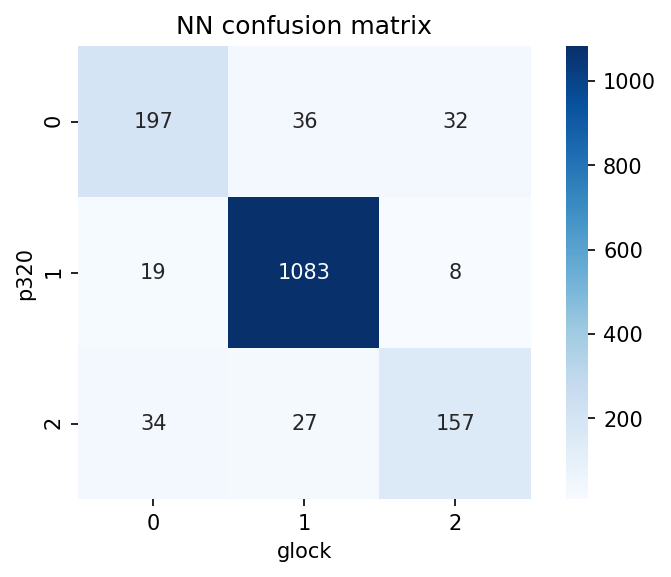

In [142]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Print confusion matrix for Gaussian
y_pred = (model.predict(x_train)>.5)
GNB_confusion = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('glock')
plt.ylabel('p320')
plt.title('NN confusion matrix  [0=glock 1=P320]');

# Print confusion matrix for Gaussian

y_pred_t = (model.predict(x_test)>.5)
rf_confusion = confusion_matrix(y_test.argmax(axis=1), y_pred_t.argmax(axis=1))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('glock')
plt.ylabel('p320')
plt.title('NN confusion matrix');

In [145]:
compute(x_test,y_test,model)

50/50 [==============================] - 0s 2ms/step - loss: 0.2474 - accuracy: 0.9014


(0.2473832219839096, 90.14438390731812)

In [ ]:
# Try using PANNS pretrained model.

In [ ]:
live stream?

In [ ]:
import sounddevice as sd
from scipy.io.wavfile import write

fs = 44100  # Sample rate
seconds = .25  # Duration of recording
sd.default.device = sd.query_devices()[1]['name']  # Speakers full name here

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2, dtype='int16')
sd.wait()  # Wait until recording is finished
write('output.wav', fs, myrecording)  # Save as WAV file


In [101]:
sd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Stereo Mix (Realtek High Defini, MME (2 in, 0 out)
   2 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
   3 Speakers (Realtek High Definiti, MME (0 in, 8 out)
   4 Realtek HD Audio 2nd output (Re, MME (0 in, 2 out)
   5 LG Ultra HD (NVIDIA High Defini, MME (0 in, 2 out)
   6 Realtek Digital Output (Realtek, MME (0 in, 2 out)
   7 ED273 A (NVIDIA High Definition, MME (0 in, 2 out)
   8 Microphone (Realtek HD Audio Mic input), Windows WDM-KS (2 in, 0 out)
   9 Line In (Realtek HD Audio Line input), Windows WDM-KS (2 in, 0 out)
  10 Speakers (Realtek HD Audio output), Windows WDM-KS (0 in, 8 out)
  11 SPDIF Out (Realtek HDA SPDIF Out), Windows WDM-KS (0 in, 2 out)
  12 Headphones (Realtek HD Audio 2nd output), Windows WDM-KS (0 in, 2 out)
  13 Stereo Mix (Realtek HD Audio Stereo input), Windows WDM-KS (2 in, 0 out)
  14 Microphone (HD Web Camera), Windows WDM-KS (1 in, 0 out)
  15 Output (NVIDIA High Definition Audio), Window

In [153]:
import pylab as pl
from IPython import display
import librosa.display

running_pred = collections.deque([[0,1,0], [0,1,0], [0,1,0], [0,1,0]])
seconds = .5

while True:
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2, dtype='int16')
    sd.wait()  # Wait until recording is finished
    write('output.wav', fs, myrecording)  # Save as WAV file 
    y, sr = librosa.load('output.wav',sr=16000)
    #fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
    #librosa.display.waveplot(y, sr=sr, ax=ax[0])
    data = extract_features('output.wav')
    data = data.reshape(1, 40,1)
    

    running_pred.appendleft(model.predict(data)[0][:])
    running_pred.pop()

    sns.barplot(np.mean(running_pred,axis=0),['glock','neither','p320'])
    plt.show()
    display.clear_output(wait=True)

KeyboardInterrupt: 

In [91]:
model.predict(data)[0][:]
import collections
#q = collections.deque([[0,1,0], [0,1,0], [0,1,0], [0,1,0]])
q.appendleft(model.predict(data)[0][:])
q.pop()
np.mean(q,axis=0)

array([2.3338904e-05, 9.9968266e-01, 2.9398224e-04], dtype=float32)

In [73]:
myrecording.astype('float32')


array([[ 3],
       [ 1],
       [ 0],
       ...,
       [ 1],
       [-1],
       [-1]], dtype=int16)

<AxesSubplot:>

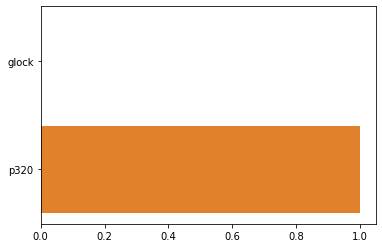

In [679]:
data = extract_features('E:/Users/atag3/Documents/Gunshot_Data/New_Samples/glock19_47.wav')
data = data.reshape(1, 40,1)
sns.barplot(model.predict(data)[0][:],['glock','p320'])

In [627]:
file_paths[0]

'E:/Users/atag3/Documents/Gunshot_Data\\glock19_handgun_9mm_1.wav'

In [168]:
mel_spect = librosa.feature.melspectrogram(y=np.squeeze(myrecording), n_fft=2048, hop_length=1024)
#mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
mel_spect.shape

(128, 216)

In [208]:
data = extract_features('output.wav')
data = data.reshape(1, 128, 732, 1)

In [212]:
model.predict_classes(x_test)

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0], dtype=int64)

Exception: Data must be 1-dimensional

In [444]:

pd.Series(np.hstack((np.mean(x_train[240], axis=1))))

0    -339.794678
1      85.996246
2     -62.353813
3      42.583145
4     -45.167839
5      21.273090
6     -16.381641
7      16.418100
8      -6.838579
9       9.794353
10     -8.219407
11      4.342877
12      2.960896
13      2.551111
14      8.307964
15     -1.509942
16      2.738114
17     -7.575241
18      8.073338
19     -8.076151
20      8.687998
21     -3.399550
22      4.063668
23     -3.694412
24      4.676907
25     -1.262598
26      0.075493
27      0.874769
28     -0.362784
29      3.015783
30     -2.434682
31      3.110865
32     -0.728069
33      6.092707
34      0.591945
35      1.827182
36     -3.853842
37      2.463609
38     -1.293721
39      4.477322
dtype: float32